In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import pyproj
import geopandas as gpd

from renewable_data_load import *
from climakitae.util.utils import clip_to_shapefile

# Regional Coincident Drought Analysis

This notebook analyzes coincident drought between solar PV and onshore wind across California utility regions using spatially-aggregated drought area fractions from `test_shapefile_clipping.ipynb`.

**Approach:**
- Regional drought threshold: `drought_area_fraction > 0.3` (30% of region in drought)
- Metrics: Days per year in PV-only, wind-only, and coincident drought
- Analysis across 4 climate models and 2 GWLs (0.8°C and 2.0°C)
- Focus on utility load zones: PG&E, SCE, SDG&E, IID, LDWP, NCNC, WECC

**Future extension:** Add offshore wind regions to assess portfolio diversification benefits.

## Setup and Configuration

In [2]:
# Set larger default font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 16

In [14]:
# Analysis parameters
drought_threshold = 0.2  # Regional drought when >30% of area in drought
target_gwls = [0.8, 2.0]
simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", "ec-earth3"]

# Utility regions (exclude north/south offshore for now)
utility_regions = ["PG&E", "SCE", "SDG&E", "IID", "LDWP", "NCNC", "WECC_NW", "WECC_SW",'WECC_MTN']

# Data paths
data_dir = Path("drought_masks")
shapefile_path = Path("../../data/load_zone_shapefiles/allLoadZones.shp")

# WRF CRS (needed for shapefiles)
wrf_crs = pyproj.CRS(
    """+proj=lcc +lat_0=38. +lon_0=-70. +lat_1=30.
    +lat_2=60. +R=6370000. +units=m +no_defs"""
)

## Load Spatial Drought Data

Load pre-computed drought area fractions for each region from `test_shapefile_clipping.ipynb`.

In [15]:
def load_regional_drought_data(region, simulation, resource, module, gwl, data_dir):
    """
    Load drought area fraction time series for a specific region.
    
    Parameters
    ----------
    region : str
        Region name (e.g., 'PG&E', 'SCE')
    simulation : str
        Climate model name
    resource : str
        'pv' or 'windpower'
    module : str
        'utility' or 'onshore'
    gwl : float
        Global warming level
    data_dir : Path
        Directory containing NetCDF files
        
    Returns
    -------
    xr.DataArray
        Drought area fraction time series
    """
    filename = f"{region}_{simulation}_{resource}_{module}_gwl{gwl}_drought_area_fraction.nc"
    filepath = data_dir / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    
    return xr.open_dataarray(filepath)

In [16]:
# Load all data into a structured dictionary
print("Loading regional drought data...")
drought_data = {}

for gwl in target_gwls:
    drought_data[gwl] = {}
    print(f"\n  GWL {gwl}°C:")
    
    for sim in simulations:
        drought_data[gwl][sim] = {}
        print(f"    {sim}...", end=" ")
        
        for region in utility_regions:
            # Load PV and wind drought fractions
            pv_data = load_regional_drought_data(
                region, sim, "pv", "utility", gwl, data_dir
            )
            wind_data = load_regional_drought_data(
                region, sim, "windpower", "onshore", gwl, data_dir
            )
            
            drought_data[gwl][sim][region] = {
                'pv': pv_data,
                'wind': wind_data
            }
        
        print("✓")

print("\n✓ All data loaded!")

Loading regional drought data...

  GWL 0.8°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

  GWL 2.0°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

✓ All data loaded!


## Calculate Coincident Drought Metrics

Apply threshold and classify each day into:
- PV-only drought
- Wind-only drought  
- Coincident drought (both)
- No drought

Calculate average days per year for each category.

In [17]:
def calculate_drought_metrics(pv_fraction, wind_fraction, threshold=0.3):
    """
    Calculate drought day statistics from area fraction time series.
    
    Parameters
    ----------
    pv_fraction : xr.DataArray
        PV drought area fraction time series
    wind_fraction : xr.DataArray
        Wind drought area fraction time series
    threshold : float
        Threshold for regional drought (default 0.3 = 30% of area)
        
    Returns
    -------
    dict
        Dictionary with counts of:
        - 'pv_only': Days with PV drought but not wind
        - 'wind_only': Days with wind drought but not PV
        - 'coincident': Days with both resources in drought
        - 'no_drought': Days with neither in drought
        - 'total_days': Total number of days
        - 'days_per_year': Days per year for each category
    """
    # Create binary masks
    pv_mask = (pv_fraction > threshold).astype(int)
    wind_mask = (wind_fraction > threshold).astype(int)
    
    # Classify each day
    pv_only = ((pv_mask == 1) & (wind_mask == 0)).sum().item()
    wind_only = ((pv_mask == 0) & (wind_mask == 1)).sum().item()
    coincident = ((pv_mask == 1) & (wind_mask == 1)).sum().item()
    no_drought = ((pv_mask == 0) & (wind_mask == 0)).sum().item()
    
    total_days = len(pv_fraction)
    years = total_days / 365.25  # Account for leap years
    
    return {
        'pv_only': pv_only,
        'wind_only': wind_only,
        'coincident': coincident,
        'no_drought': no_drought,
        'total_days': total_days,
        'pv_only_per_year': pv_only / years,
        'wind_only_per_year': wind_only / years,
        'coincident_per_year': coincident / years,
        'no_drought_per_year': no_drought / years
    }

In [18]:
# Calculate metrics for all combinations
print("Calculating drought metrics...")
drought_metrics = {}

for gwl in target_gwls:
    drought_metrics[gwl] = {}
    print(f"\n  GWL {gwl}°C:")
    
    for sim in simulations:
        drought_metrics[gwl][sim] = {}
        print(f"    {sim}...", end=" ")
        
        for region in utility_regions:
            pv_data = drought_data[gwl][sim][region]['pv']
            wind_data = drought_data[gwl][sim][region]['wind']
            
            metrics = calculate_drought_metrics(
                pv_data, wind_data, threshold=drought_threshold
            )
            drought_metrics[gwl][sim][region] = metrics
        
        print("✓")

print("\n✓ Metrics calculated!")

Calculating drought metrics...

  GWL 0.8°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

  GWL 2.0°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

✓ Metrics calculated!


## Convert to DataFrame for Easier Analysis

In [19]:
# Convert nested dict to DataFrame for easier plotting
rows = []
for gwl in target_gwls:
    for sim in simulations:
        for region in utility_regions:
            metrics = drought_metrics[gwl][sim][region]
            rows.append({
                'gwl': gwl,
                'simulation': sim,
                'region': region,
                'pv_only_days_per_year': metrics['pv_only_per_year'],
                'wind_only_days_per_year': metrics['wind_only_per_year'],
                'coincident_days_per_year': metrics['coincident_per_year'],
                'no_drought_days_per_year': metrics['no_drought_per_year']
            })

df = pd.DataFrame(rows)
print(f"Created DataFrame with {len(df)} rows")
df.head(20)

Created DataFrame with 72 rows


,gwl,simulation,region,pv_only_days_per_year,wind_only_days_per_year,coincident_days_per_year,no_drought_days_per_year
0,0.8,mpi-esm1-2-hr,PG&E,29.353425,3.735890,0.633767,331.526918
1,0.8,mpi-esm1-2-hr,SCE,25.884384,7.771986,1.267534,330.326096
2,0.8,mpi-esm1-2-hr,SDG&E,30.587603,14.343151,2.368288,317.950959
3,0.8,mpi-esm1-2-hr,IID,34.890548,37.292192,7.738630,285.328630
4,0.8,mpi-esm1-2-hr,LDWP,28.286027,10.407123,1.801233,324.755616
5,0.8,mpi-esm1-2-hr,NCNC,28.386096,10.206986,1.434315,325.222603
6,0.8,mpi-esm1-2-hr,WECC_NW,24.149863,12.541918,0.166781,328.391438
7,0.8,mpi-esm1-2-hr,WECC_SW,34.223425,23.549452,2.001370,305.475753
8,0.8,mpi-esm1-2-hr,WECC_MTN,28.886438,23.082466,1.167466,312.113630
9,0.8,miroc6,PG&E,28.085890,2.435000,0.800548,333.928562


## Figure 1: Bar Charts - Coincident Drought by Region and GWL

Compare GWL 0.8 vs 2.0 for each model separately.

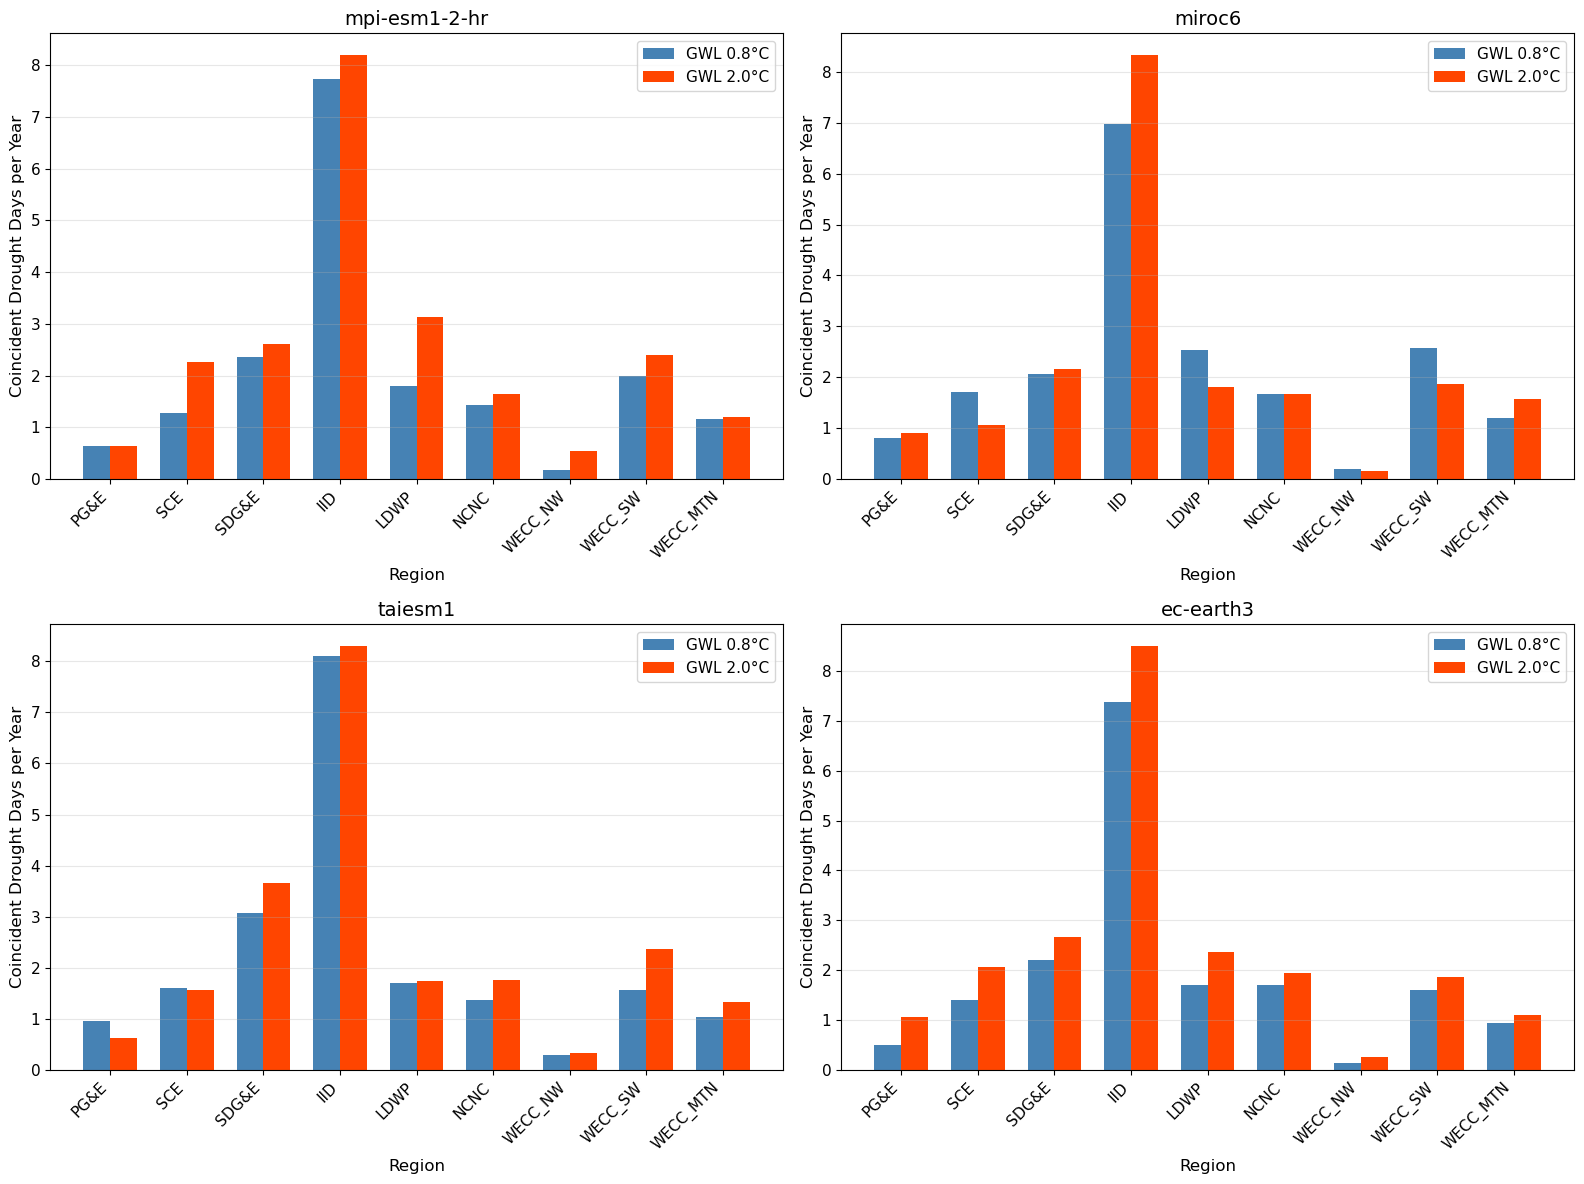

In [20]:
# Bar chart: GWL comparison for coincident drought
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, sim in enumerate(simulations):
    ax = axes[idx]
    
    # Filter data for this simulation
    sim_data = df[df['simulation'] == sim]
    
    # Prepare data for grouped bar chart
    x = np.arange(len(utility_regions))
    width = 0.35
    
    gwl08_data = sim_data[sim_data['gwl'] == 0.8].set_index('region')['coincident_days_per_year']
    gwl20_data = sim_data[sim_data['gwl'] == 2.0].set_index('region')['coincident_days_per_year']
    
    # Ensure regions are in same order
    gwl08_values = [gwl08_data.loc[r] for r in utility_regions]
    gwl20_values = [gwl20_data.loc[r] for r in utility_regions]
    
    # Create bars
    bars1 = ax.bar(x - width/2, gwl08_values, width, label='GWL 0.8°C', color='steelblue')
    bars2 = ax.bar(x + width/2, gwl20_values, width, label='GWL 2.0°C', color='orangered')
    
    # Formatting
    ax.set_xlabel('Region')
    ax.set_ylabel('Coincident Drought Days per Year')
    ax.set_title(f'{sim}')
    ax.set_xticks(x)
    ax.set_xticklabels(utility_regions, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('coincident_drought_by_region_gwl_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 2: Stacked Bar Charts - Drought Type Breakdown

Show PV-only, wind-only, and coincident drought days for each region.

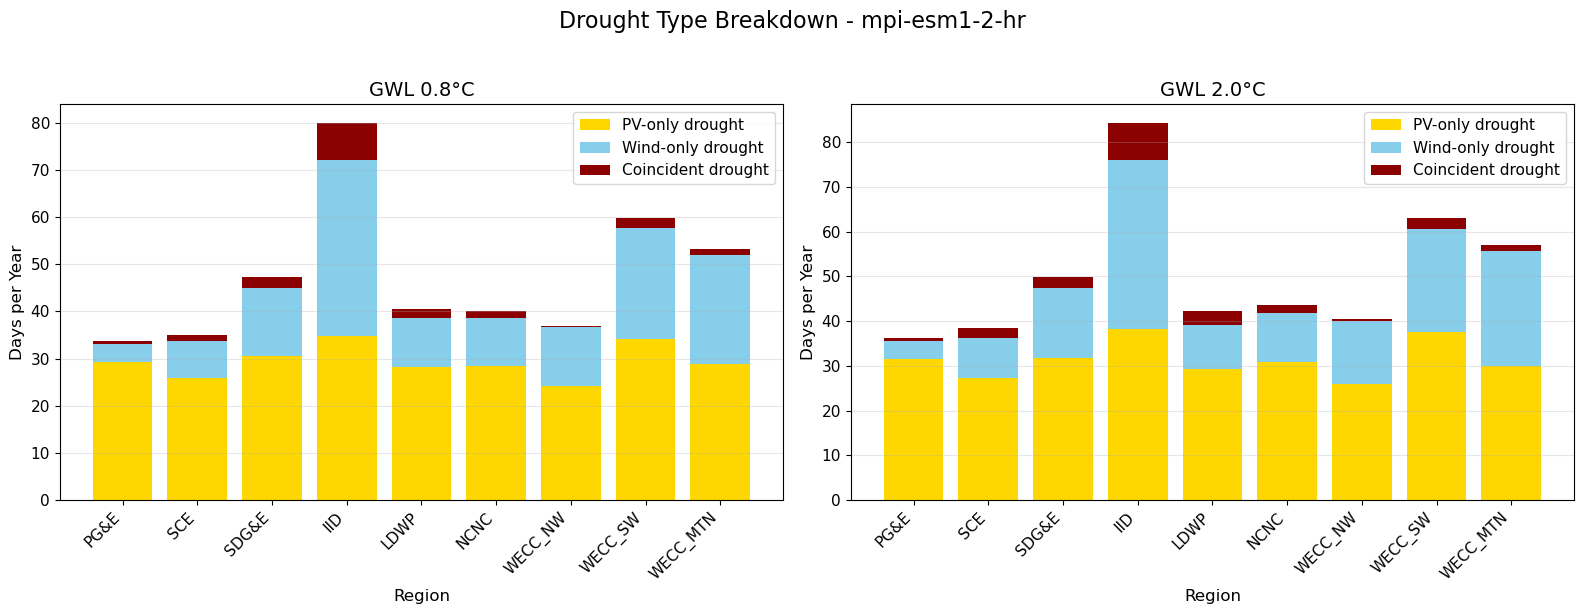

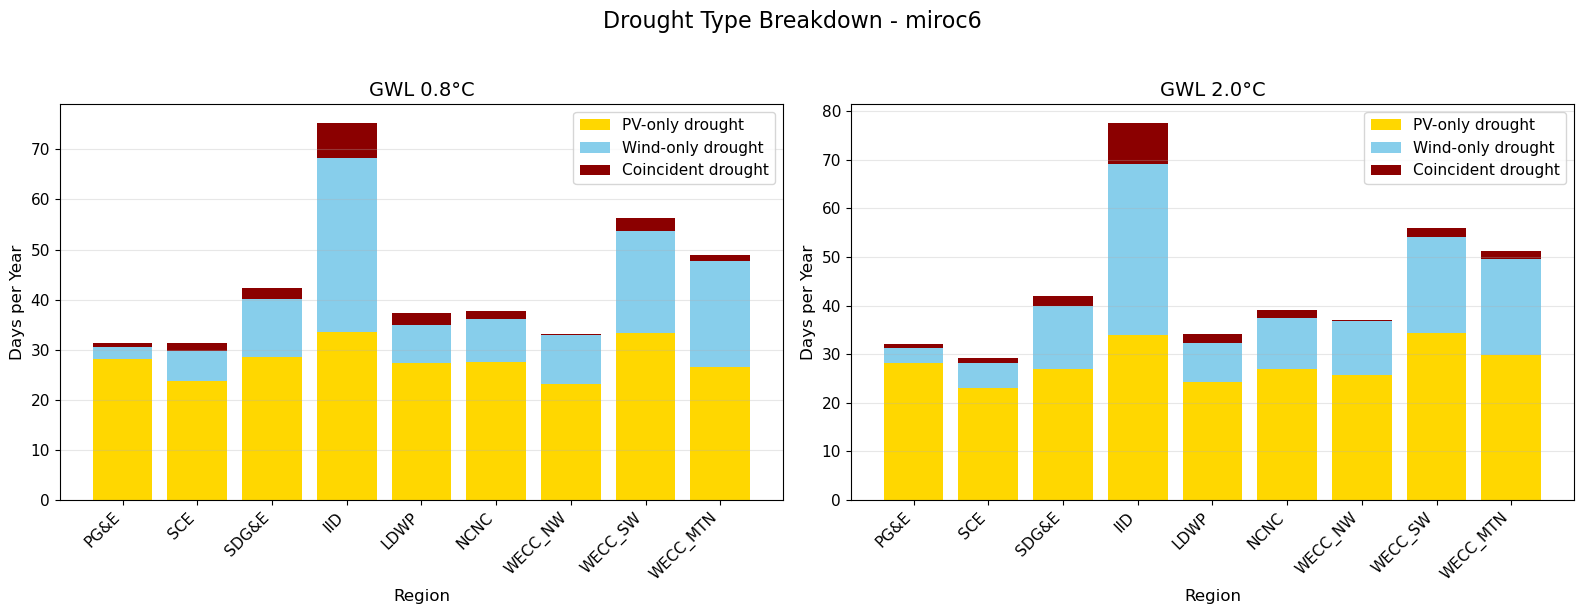

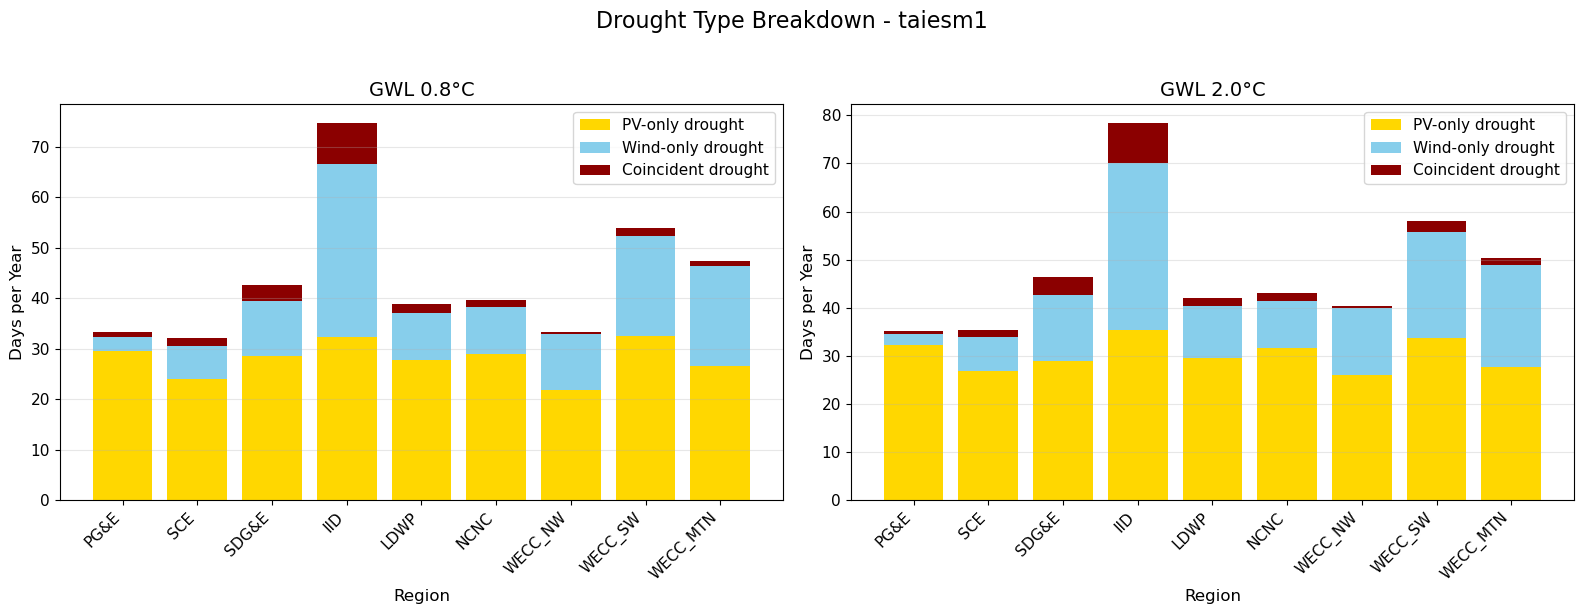

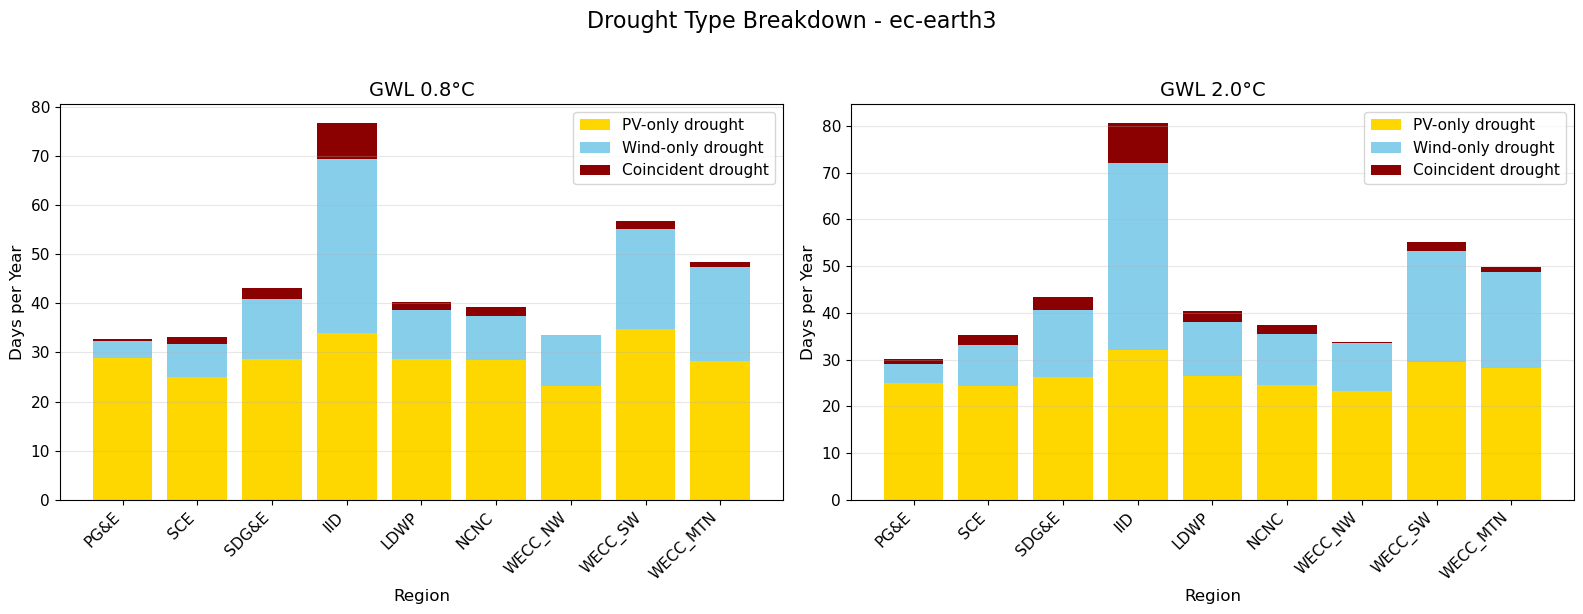

In [21]:
# Stacked bar chart showing drought type breakdown
# One figure per model, with GWL panels side-by-side

for sim in simulations:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for idx, gwl in enumerate(target_gwls):
        ax = axes[idx]
        
        # Filter data
        data = df[(df['simulation'] == sim) & (df['gwl'] == gwl)].set_index('region')
        
        # Stack components
        x = np.arange(len(utility_regions))
        pv_only = [data.loc[r, 'pv_only_days_per_year'] for r in utility_regions]
        wind_only = [data.loc[r, 'wind_only_days_per_year'] for r in utility_regions]
        coincident = [data.loc[r, 'coincident_days_per_year'] for r in utility_regions]
        
        # Create stacked bars
        ax.bar(x, pv_only, label='PV-only drought', color='gold')
        ax.bar(x, wind_only, bottom=pv_only, label='Wind-only drought', color='skyblue')
        ax.bar(x, coincident, bottom=np.array(pv_only) + np.array(wind_only), 
               label='Coincident drought', color='darkred')
        
        # Formatting
        ax.set_xlabel('Region')
        ax.set_ylabel('Days per Year')
        ax.set_title(f'GWL {gwl}°C')
        ax.set_xticks(x)
        ax.set_xticklabels(utility_regions, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    fig.suptitle(f'Drought Type Breakdown - {sim}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f'drought_breakdown_stacked_{sim}.png', dpi=300, bbox_inches='tight')
    plt.show()

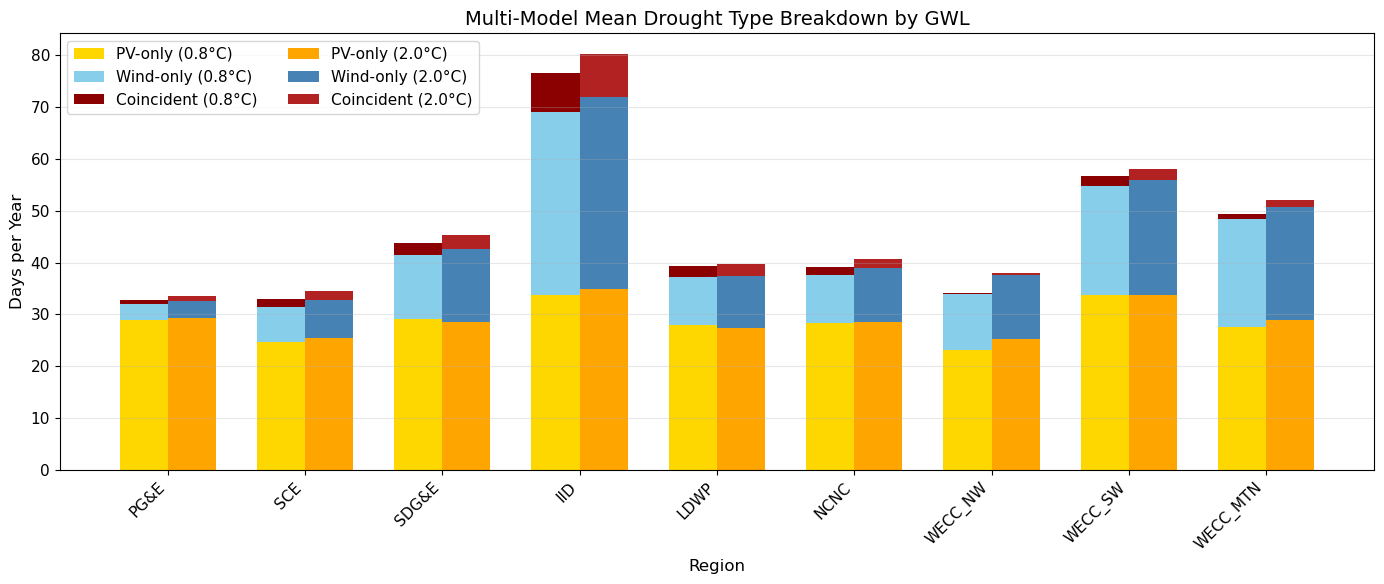

In [25]:
# Calculate multi-model mean for each region and GWL
ensemble_data = df.groupby(['region', 'gwl']).agg({
    'pv_only_days_per_year': 'mean',
    'wind_only_days_per_year': 'mean',
    'coincident_days_per_year': 'mean',
    'no_drought_days_per_year': 'mean'
}).reset_index()

# Create grouped stacked bar chart
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

x = np.arange(len(utility_regions))
width = 0.35

for idx, gwl in enumerate(target_gwls):
    gwl_data = ensemble_data[ensemble_data['gwl'] == gwl].set_index('region')
    
    # Get values in correct order
    pv_only = [gwl_data.loc[r, 'pv_only_days_per_year'] for r in utility_regions]
    wind_only = [gwl_data.loc[r, 'wind_only_days_per_year'] for r in utility_regions]
    coincident = [gwl_data.loc[r, 'coincident_days_per_year'] for r in utility_regions]
    
    # Position for this GWL's bars
    pos = x + (idx - 0.5) * width
    
    # Color scheme
    if gwl == 0.8:
        pv_color = 'gold'
        wind_color = 'skyblue'
        coin_color = 'darkred'
        label_suffix = ' (0.8°C)'
    else:
        pv_color = 'orange'
        wind_color = 'steelblue'
        coin_color = 'firebrick'
        label_suffix = ' (2.0°C)'
    
    # Create stacked bars
    ax.bar(pos, pv_only, width, label=f'PV-only{label_suffix}', color=pv_color)
    ax.bar(pos, wind_only, width, bottom=pv_only, 
           label=f'Wind-only{label_suffix}', color=wind_color)
    ax.bar(pos, coincident, width, bottom=np.array(pv_only) + np.array(wind_only), 
           label=f'Coincident{label_suffix}', color=coin_color)

# Formatting
ax.set_xlabel('Region')
ax.set_ylabel('Days per Year')
ax.set_title('Multi-Model Mean Drought Type Breakdown by GWL', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(utility_regions, rotation=45, ha='right')
ax.legend(ncol=2, loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('drought_breakdown_multimodel_gwl_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 2b: Multi-Model Mean Stacked Bars - GWL Comparison

Show ensemble mean with GWL 0.8 and 2.0 side-by-side for easier comparison of climate change impacts.

## Figure 3: Heatmaps - Coincident Drought Across Regions and Models

Show spatial patterns of coincident drought frequency.

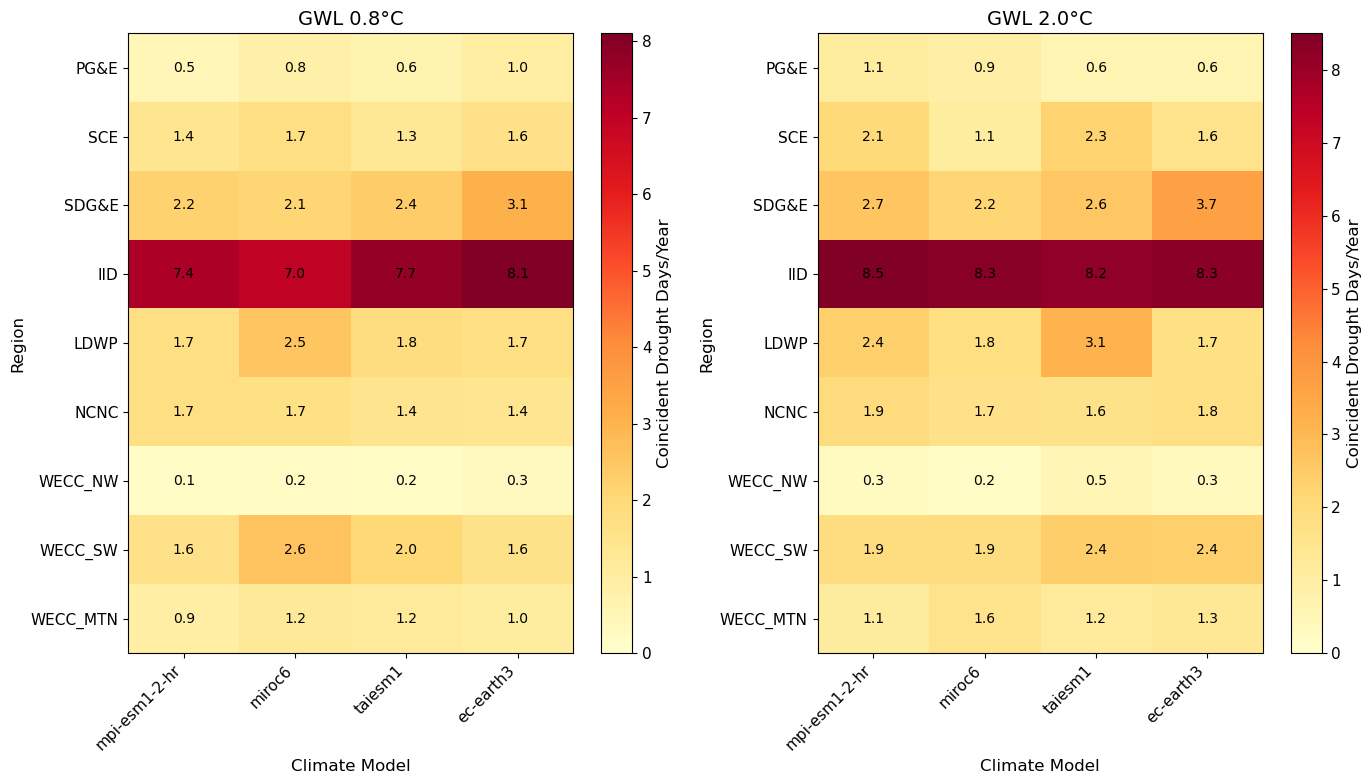

In [22]:
# Heatmap: regions (rows) x models (columns) for each GWL
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

for idx, gwl in enumerate(target_gwls):
    ax = axes[idx]
    
    # Pivot data to create matrix: regions x models
    data = df[df['gwl'] == gwl].pivot(
        index='region', 
        columns='simulation', 
        values='coincident_days_per_year'
    )
    
    # Reorder to match utility_regions list
    data = data.reindex(utility_regions)
    
    # Create heatmap
    im = ax.imshow(data.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=data.values.max())
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(simulations)))
    ax.set_yticks(np.arange(len(utility_regions)))
    ax.set_xticklabels(simulations, rotation=45, ha='right')
    ax.set_yticklabels(utility_regions)
    
    # Add values as text
    for i in range(len(utility_regions)):
        for j in range(len(simulations)):
            text = ax.text(j, i, f'{data.values[i, j]:.1f}',
                          ha="center", va="center", color="black", fontsize=10)
    
    ax.set_title(f'GWL {gwl}°C')
    ax.set_xlabel('Climate Model')
    ax.set_ylabel('Region')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Coincident Drought Days/Year')

plt.tight_layout()
plt.savefig('coincident_drought_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 4: Choropleth Maps - Spatial Distribution of Coincident Drought

Use shapefiles to visualize coincident drought frequency by region.

In [23]:
# Load shapefile
gdf = gpd.read_file(shapefile_path)
print(f"Loaded shapefile with {len(gdf)} regions")
print(f"Region names: {gdf['name'].tolist()}")

Loaded shapefile with 9 regions
Region names: ['PG&E', 'IID', 'LDWP', 'NCNC', 'SCE', 'SDG&E', 'WECC_NW', 'WECC_SW', 'WECC_MTN']


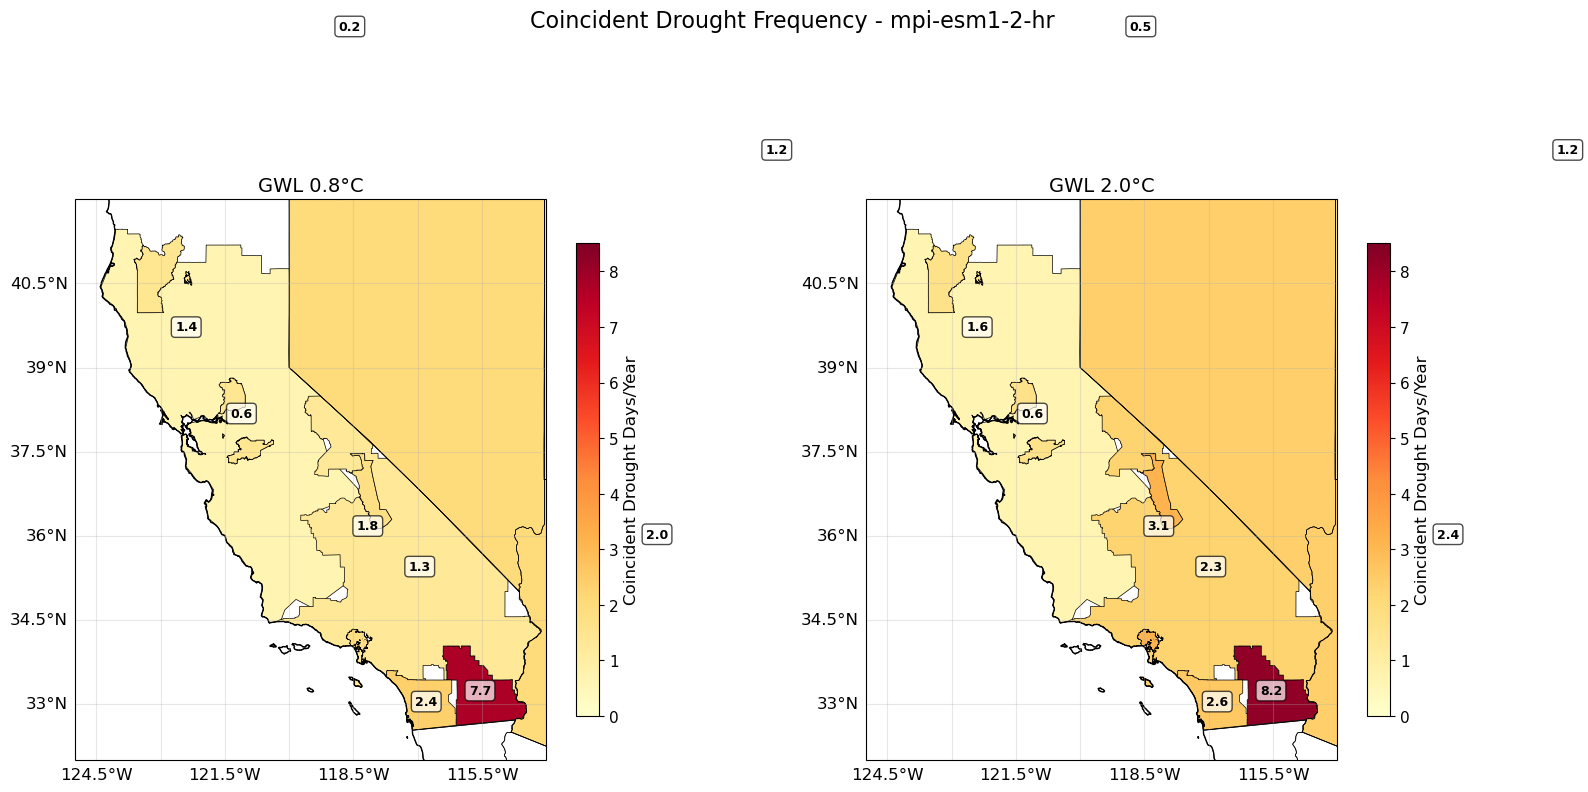

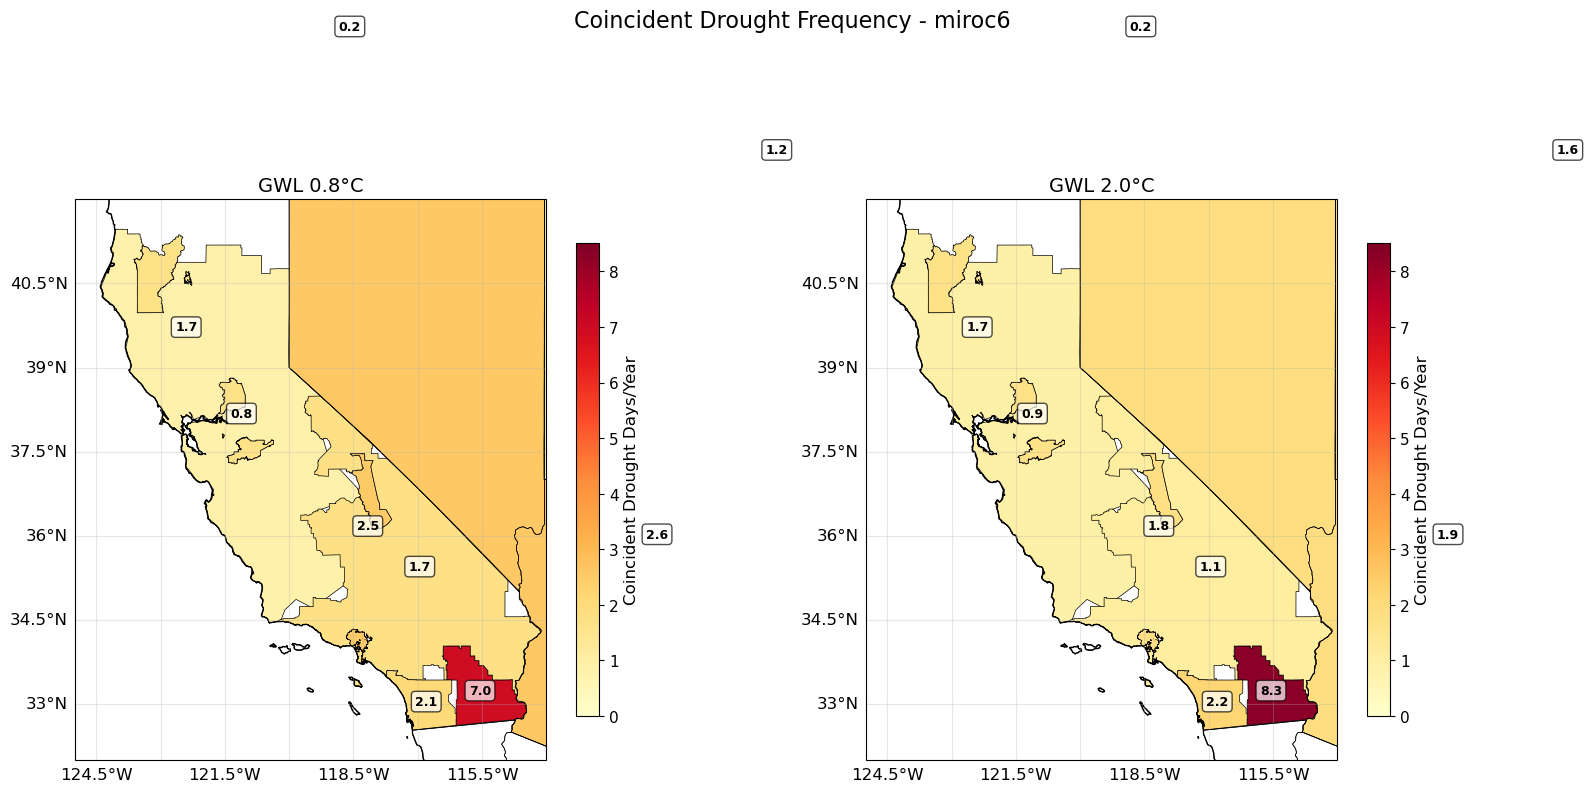

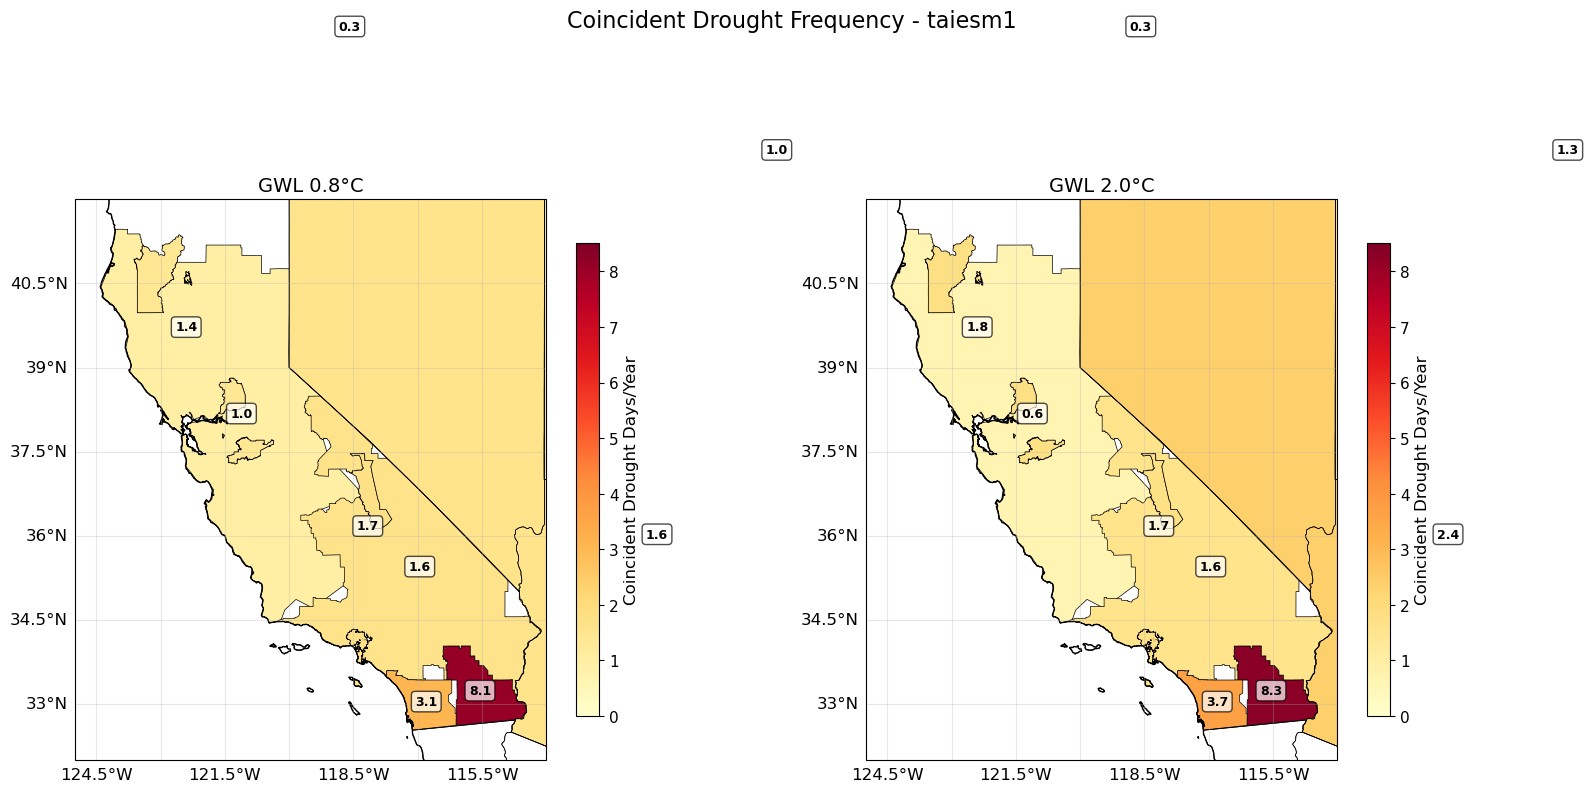

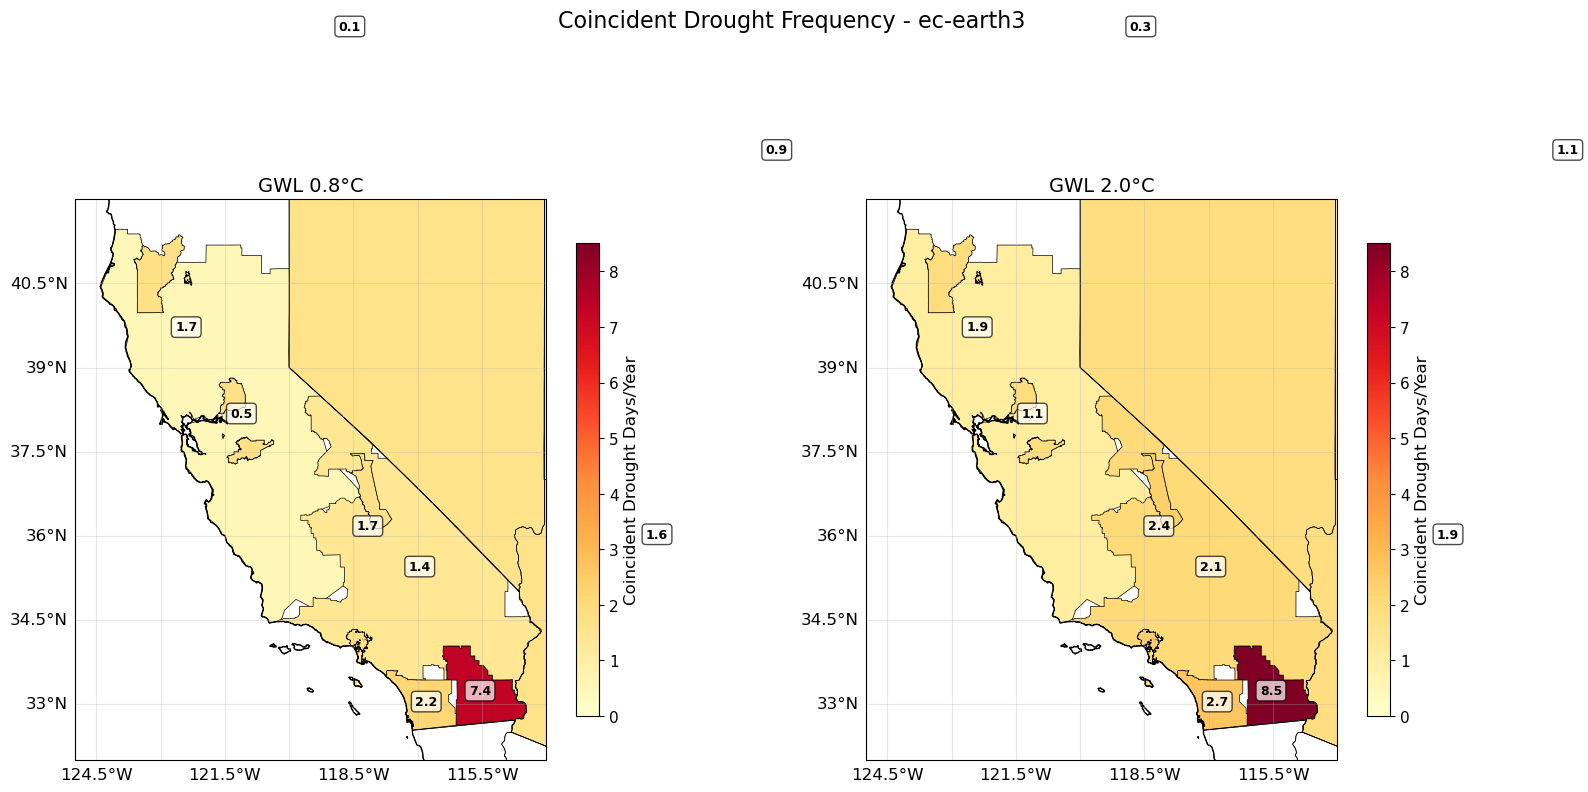

In [24]:
# Choropleth maps: one figure per model showing both GWLs
for sim in simulations:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    for idx, gwl in enumerate(target_gwls):
        ax = axes[idx]
        
        # Get coincident drought data for this model/GWL
        data = df[(df['simulation'] == sim) & (df['gwl'] == gwl)].set_index('region')
        
        # Merge with shapefile
        gdf_plot = gdf.copy()
        gdf_plot['coincident_days'] = gdf_plot['name'].map(
            lambda x: data.loc[x, 'coincident_days_per_year'] if x in data.index else np.nan
        )
        
        # Plot
        gdf_plot.plot(
            column='coincident_days',
            ax=ax,
            cmap='YlOrRd',
            edgecolor='black',
            linewidth=0.5,
            legend=True,
            vmin=0,
            vmax=df['coincident_days_per_year'].max(),
            legend_kwds={'label': 'Coincident Drought Days/Year', 'shrink': 0.8}
        )
        
        # Add region labels
        for idx_region, row in gdf_plot.iterrows():
            if pd.notna(row['coincident_days']):
                centroid = row.geometry.centroid
                ax.text(
                    centroid.x, centroid.y, 
                    f"{row['coincident_days']:.1f}",
                    ha='center', va='center', 
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
                )
        
        # Formatting
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linewidth=0.5)
        ax.set_title(f'GWL {gwl}°C')
        ax.set_extent([-125, -114, 32, 42])  # California bounds
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, alpha=0.3)
        gl.top_labels = False
        gl.right_labels = False
    
    fig.suptitle(f'Coincident Drought Frequency - {sim}', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig(f'choropleth_coincident_drought_{sim}.png', dpi=300, bbox_inches='tight')
    plt.show()

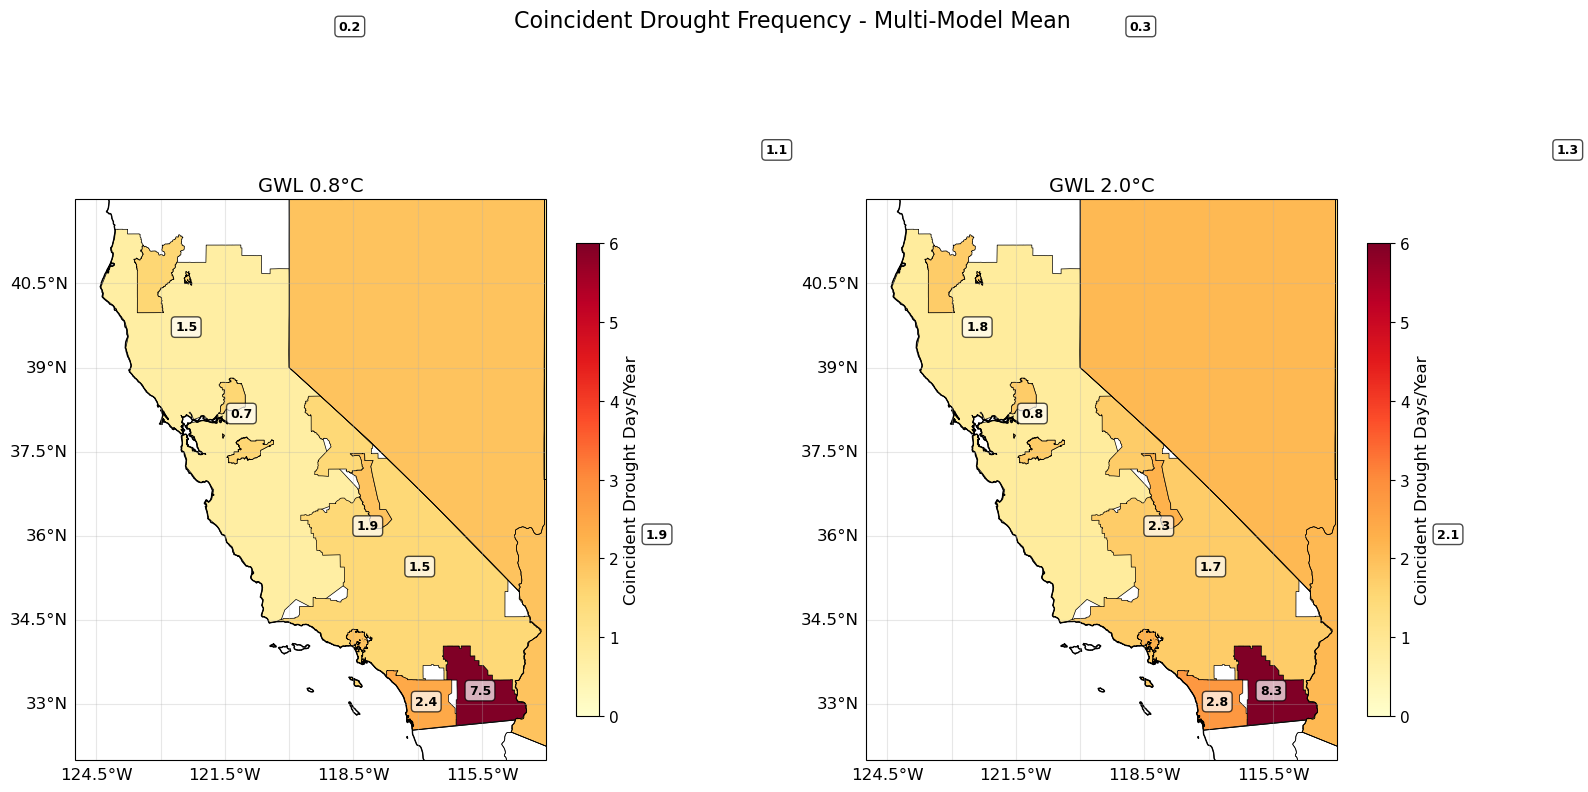

In [48]:
# Multi-model mean choropleth map
fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Calculate multi-model mean for coincident drought
ensemble_choropleth = df.groupby(['region', 'gwl'])['coincident_days_per_year'].mean().reset_index()

for idx, gwl in enumerate(target_gwls):
    ax = axes[idx]
    
    # Get ensemble mean data for this GWL
    data = ensemble_choropleth[ensemble_choropleth['gwl'] == gwl].set_index('region')
    
    # Merge with shapefile
    gdf_plot = gdf.copy()
    gdf_plot['coincident_days'] = gdf_plot['name'].map(
        lambda x: data.loc[x, 'coincident_days_per_year'] if x in data.index else np.nan
    )
    
    # Plot
    gdf_plot.plot(
        column='coincident_days',
        ax=ax,
        cmap='YlOrRd',
        edgecolor='black',
        linewidth=0.5,
        legend=True,
        vmin=0,
        vmax=6,
        legend_kwds={'label': 'Coincident Drought Days/Year', 'shrink': 0.8}
    )
    
    # Add region labels
    for idx_region, row in gdf_plot.iterrows():
        if pd.notna(row['coincident_days']):
            centroid = row.geometry.centroid
            ax.text(
                centroid.x, centroid.y, 
                f"{row['coincident_days']:.1f}",
                ha='center', va='center', 
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
            )
    
    # Formatting
    ax.coastlines()
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.set_title(f'GWL {gwl}°C')
    ax.set_extent([-125, -114, 32, 42])  # California bounds
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False

fig.suptitle('Coincident Drought Frequency - Multi-Model Mean', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig('choropleth_coincident_drought_multimodel.png', dpi=300, bbox_inches='tight')
plt.show()

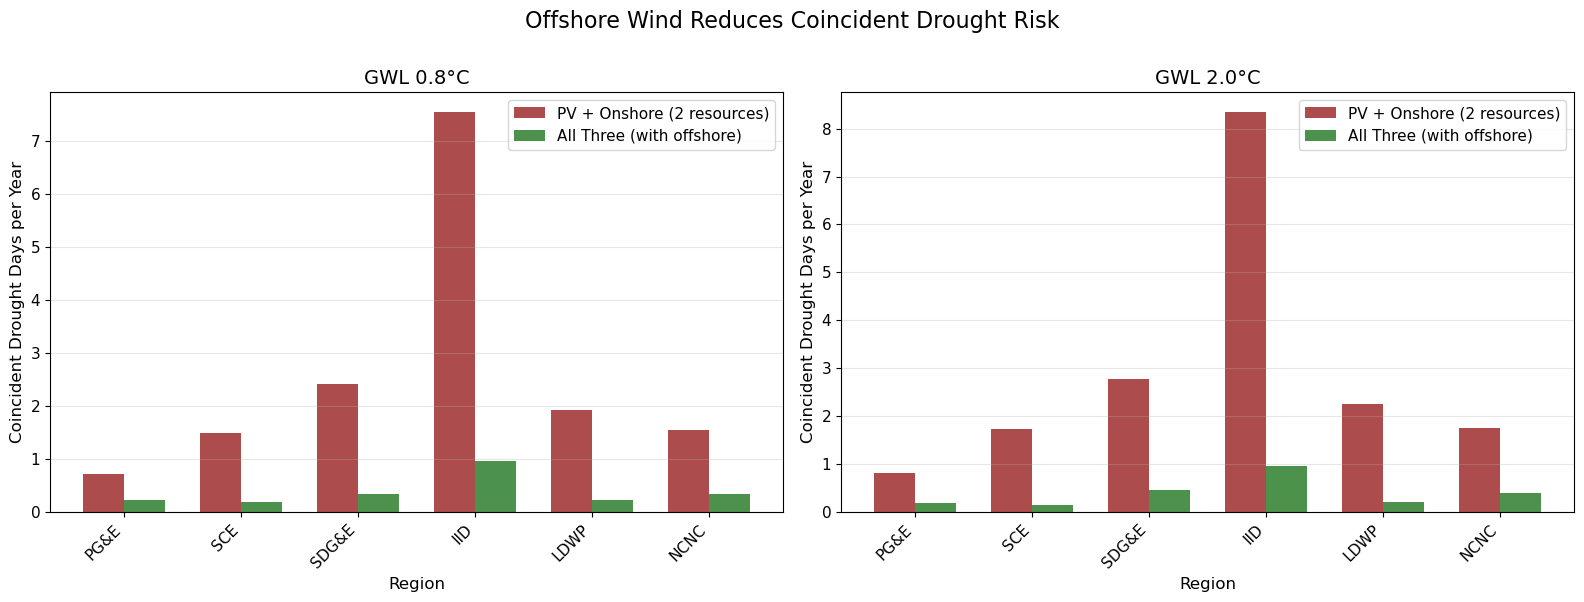

In [35]:
# Compare 2-resource (PV+onshore) vs 3-resource (all three) coincident drought
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, gwl in enumerate(target_gwls):
    ax = axes[idx]
    
    # Get 2-resource data (from original df)
    df_2resource_gwl = df[
        (df['gwl'] == gwl) & 
        (df['region'].isin(utility_regions_3resource))
    ]
    coincident_2resource = df_2resource_gwl.groupby('region')['coincident_days_per_year'].mean()
    
    # Get 3-resource data
    data_3resource = ensemble_3resource[ensemble_3resource['gwl'] == gwl].set_index('region')
    
    x = np.arange(len(utility_regions_3resource))
    width = 0.35
    
    # Get values in correct order
    two_resource_values = [coincident_2resource.loc[r] for r in utility_regions_3resource]
    three_resource_values = [data_3resource.loc[r, 'all_three_per_year'] for r in utility_regions_3resource]
    
    # Calculate reduction
    reduction_pct = [(two - three) / two * 100 if two > 0 else 0 
                     for two, three in zip(two_resource_values, three_resource_values)]
    
    # Create bars
    bars1 = ax.bar(x - width/2, two_resource_values, width, 
                   label='PV + Onshore (2 resources)', color='darkred', alpha=0.7)
    bars2 = ax.bar(x + width/2, three_resource_values, width, 
                   label='All Three (with offshore)', color='darkgreen', alpha=0.7)
    
    # # Add reduction percentage as text
    # for i, (v1, v2, pct) in enumerate(zip(two_resource_values, three_resource_values, reduction_pct)):
    #     if pct > 0:
    #         ax.text(i, max(v1, v2) + 0.5, f'-{pct:.0f}%', 
    #                ha='center', fontsize=9, fontweight='bold', color='darkgreen')
    
    # Formatting
    ax.set_xlabel('Region')
    ax.set_ylabel('Coincident Drought Days per Year')
    ax.set_title(f'GWL {gwl}°C')
    ax.set_xticks(x)
    ax.set_xticklabels(utility_regions_3resource, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

fig.suptitle('Offshore Wind Reduces Coincident Drought Risk', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('offshore_wind_benefit_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

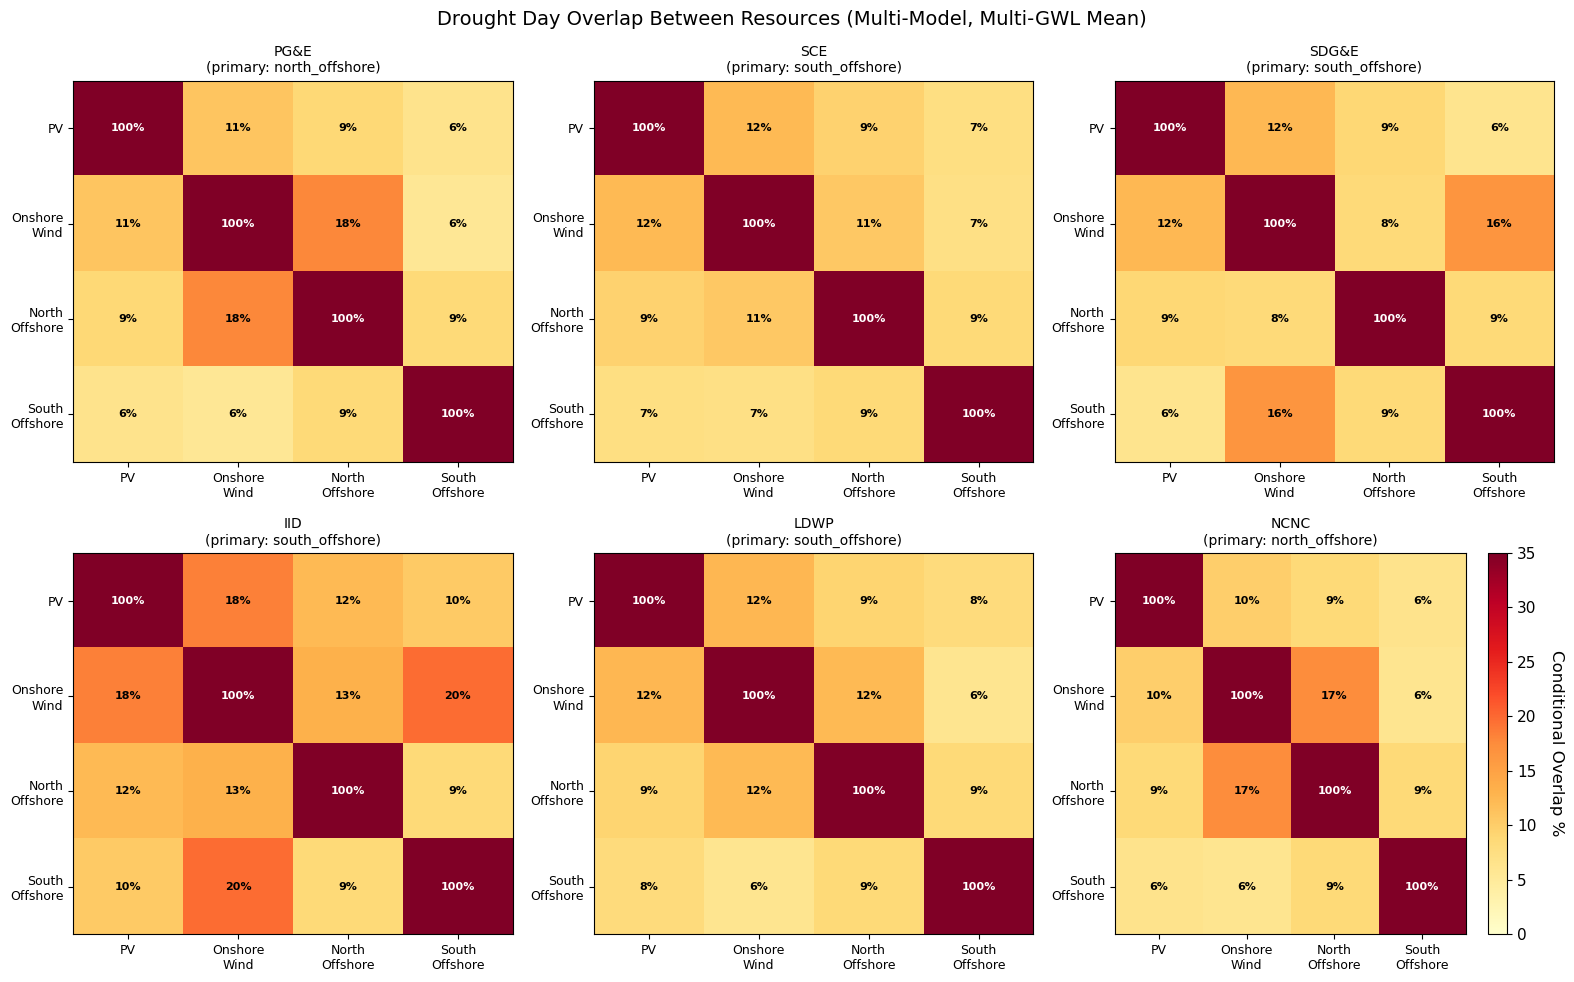

In [46]:
# Calculate overlap matrices for each region (using multi-model mean approach)
# Average across all models and GWLs for a representative view
# Show all 4 resources: PV, Onshore, North Offshore, South Offshore

resource_labels = ['PV', 'Onshore\nWind', 'North\nOffshore', 'South\nOffshore']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, region in enumerate(utility_regions_3resource):
    ax = axes[idx]
    
    # Collect matrices across all models and GWLs, then average
    matrices = []
    
    for gwl in target_gwls:
        for sim in simulations:
            pv_data = drought_data[gwl][sim][region]['pv']
            onshore_data = drought_data[gwl][sim][region]['wind']
            north_offshore_data = offshore_data[gwl][sim]['north_offshore']
            south_offshore_data = offshore_data[gwl][sim]['south_offshore']
            
            matrix = calculate_drought_overlap_matrix(
                pv_data, onshore_data, north_offshore_data, south_offshore_data,
                threshold=drought_threshold
            )
            matrices.append(matrix)
    
    # Average across all models and GWLs
    avg_matrix = np.mean(matrices, axis=0)
    
    # Create heatmap (0-100% scale for conditional overlap)
    im = ax.imshow(avg_matrix, cmap='YlOrRd', vmin=0, vmax=35, aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    ax.set_xticklabels(resource_labels, fontsize=9)
    ax.set_yticklabels(resource_labels, fontsize=9)
    
    # Rotate x labels for readability
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    
    # Add percentage values as text
    for i in range(4):
        for j in range(4):
            color = 'white' if avg_matrix[i, j] > 50 else 'black'
            text = ax.text(j, i, f'{avg_matrix[i, j]:.0f}%',
                          ha="center", va="center", color=color, 
                          fontsize=8, fontweight='bold')
    
    # Title with region name and primary offshore pairing
    paired_offshore = offshore_mapping[region]
    ax.set_title(f'{region}\n(primary: {paired_offshore})', fontsize=10)
    
    # Add colorbar to last plot
    if idx == len(utility_regions_3resource) - 1:
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Conditional Overlap %', rotation=270, labelpad=20)

fig.suptitle('Drought Day Overlap Between Resources (Multi-Model, Multi-GWL Mean)', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.savefig('drought_overlap_heatmaps_by_region.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
def calculate_drought_overlap_matrix(pv_fraction, onshore_fraction, north_offshore_fraction, south_offshore_fraction, threshold=0.3):
    """
    Calculate conditional overlap percentages between drought days for four resources.
    
    Returns a 4x4 matrix where:
    - Diagonal = 100% (resource always overlaps with itself)
    - Off-diagonal [i,j] = conditional probability that resource j is in drought 
      given resource i is in drought, averaged with [j,i] for symmetry
    
    Parameters
    ----------
    pv_fraction, onshore_fraction, north_offshore_fraction, south_offshore_fraction : xr.DataArray
        Drought area fractions for each resource
    threshold : float
        Drought threshold
        
    Returns
    -------
    np.ndarray
        4x4 symmetric matrix of conditional overlap percentages
    """
    # Create binary masks
    masks = [
        (pv_fraction > threshold).values,
        (onshore_fraction > threshold).values,
        (north_offshore_fraction > threshold).values,
        (south_offshore_fraction > threshold).values
    ]
    
    # Calculate conditional overlaps
    matrix = np.zeros((4, 4))
    
    for i in range(4):
        for j in range(4):
            if i == j:
                # Diagonal: 100% (resource always overlaps with itself)
                matrix[i, j] = 100.0
            else:
                # Off-diagonal: conditional probability
                # P(j in drought | i in drought) = P(both in drought) / P(i in drought)
                both_in_drought = (masks[i] & masks[j]).sum()
                i_in_drought = masks[i].sum()
                
                if i_in_drought > 0:
                    cond_prob_ij = (both_in_drought / i_in_drought) * 100
                else:
                    cond_prob_ij = 0
                
                # Calculate the reverse: P(i | j)
                j_in_drought = masks[j].sum()
                if j_in_drought > 0:
                    cond_prob_ji = (both_in_drought / j_in_drought) * 100
                else:
                    cond_prob_ji = 0
                
                # Average for symmetric matrix
                matrix[i, j] = (cond_prob_ij + cond_prob_ji) / 2
    
    return matrix

## Figure 7: Drought Overlap Heatmaps by Region

Show correlation/overlap between drought days for each resource pair in each region.

## Figure 6: Before/After Comparison - Benefits of Adding Offshore Wind

Compare 2-resource coincident drought (PV + onshore) vs 3-resource coincident drought (all three) to show diversification benefit.

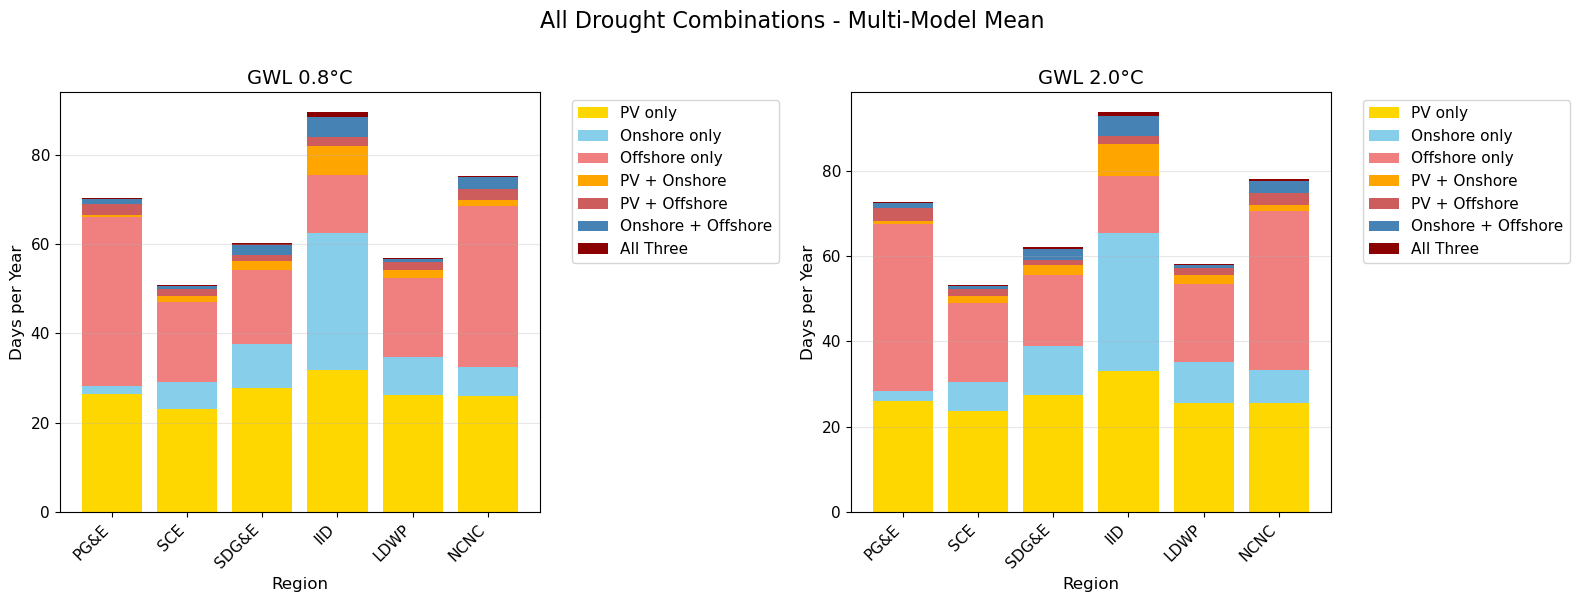

In [33]:
# Calculate multi-model mean
ensemble_3resource = df_3resource.groupby(['region', 'gwl']).mean(numeric_only=True).reset_index()

# Create figure with both GWLs side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, gwl in enumerate(target_gwls):
    ax = axes[idx]
    data = ensemble_3resource[ensemble_3resource['gwl'] == gwl].set_index('region')
    
    x = np.arange(len(utility_regions_3resource))
    
    # Get values in correct order
    pv_only = [data.loc[r, 'pv_only_per_year'] for r in utility_regions_3resource]
    onshore_only = [data.loc[r, 'onshore_only_per_year'] for r in utility_regions_3resource]
    offshore_only = [data.loc[r, 'offshore_only_per_year'] for r in utility_regions_3resource]
    pv_onshore = [data.loc[r, 'pv_onshore_per_year'] for r in utility_regions_3resource]
    pv_offshore = [data.loc[r, 'pv_offshore_per_year'] for r in utility_regions_3resource]
    onshore_offshore = [data.loc[r, 'onshore_offshore_per_year'] for r in utility_regions_3resource]
    all_three = [data.loc[r, 'all_three_per_year'] for r in utility_regions_3resource]
    
    # Stack all components
    bottom = np.zeros(len(utility_regions_3resource))
    
    # Single resources
    ax.bar(x, pv_only, label='PV only', color='gold', bottom=bottom)
    bottom += pv_only
    
    ax.bar(x, onshore_only, label='Onshore only', color='skyblue', bottom=bottom)
    bottom += onshore_only
    
    ax.bar(x, offshore_only, label='Offshore only', color='lightcoral', bottom=bottom)
    bottom += offshore_only
    
    # Two-resource combinations
    ax.bar(x, pv_onshore, label='PV + Onshore', color='orange', bottom=bottom)
    bottom += pv_onshore
    
    ax.bar(x, pv_offshore, label='PV + Offshore', color='indianred', bottom=bottom)
    bottom += pv_offshore
    
    ax.bar(x, onshore_offshore, label='Onshore + Offshore', color='steelblue', bottom=bottom)
    bottom += onshore_offshore
    
    # All three
    ax.bar(x, all_three, label='All Three', color='darkred', bottom=bottom)
    
    # Formatting
    ax.set_xlabel('Region')
    ax.set_ylabel('Days per Year')
    ax.set_title(f'GWL {gwl}°C')
    ax.set_xticks(x)
    ax.set_xticklabels(utility_regions_3resource, rotation=45, ha='right')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', alpha=0.3)

fig.suptitle('All Drought Combinations - Multi-Model Mean', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('three_resource_all_combinations.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 5: All Drought Combinations - Multi-Model Mean

Stacked bar chart showing all 7 drought combinations (excluding no-drought state).

In [31]:
# Convert to DataFrame
rows_3resource = []
for gwl in target_gwls:
    for sim in simulations:
        for region in utility_regions_3resource:
            metrics = three_resource_metrics[gwl][sim][region]
            rows_3resource.append({
                'gwl': gwl,
                'simulation': sim,
                'region': region,
                'offshore_region': offshore_mapping[region],
                'no_drought_per_year': metrics['no_drought_per_year'],
                'pv_only_per_year': metrics['pv_only_per_year'],
                'onshore_only_per_year': metrics['onshore_only_per_year'],
                'offshore_only_per_year': metrics['offshore_only_per_year'],
                'pv_onshore_per_year': metrics['pv_onshore_per_year'],
                'pv_offshore_per_year': metrics['pv_offshore_per_year'],
                'onshore_offshore_per_year': metrics['onshore_offshore_per_year'],
                'all_three_per_year': metrics['all_three_per_year']
            })

df_3resource = pd.DataFrame(rows_3resource)
print(f"Created 3-resource DataFrame with {len(df_3resource)} rows")
df_3resource.head(10)

Created 3-resource DataFrame with 48 rows


,gwl,simulation,region,offshore_region,no_drought_per_year,pv_only_per_year,onshore_only_per_year,offshore_only_per_year,pv_onshore_per_year,pv_offshore_per_year,onshore_offshore_per_year,all_three_per_year
0,0.8,mpi-esm1-2-hr,PG&E,north_offshore,293.000548,26.851712,2.301575,38.526370,0.366918,2.501712,1.434315,0.266849
1,0.8,mpi-esm1-2-hr,SCE,south_offshore,312.280411,24.550137,6.938082,18.045685,1.100753,1.334247,0.833904,0.166781
2,0.8,mpi-esm1-2-hr,SDG&E,south_offshore,302.173493,29.386781,11.174315,15.777466,2.134795,1.200822,3.168836,0.233493
3,0.8,mpi-esm1-2-hr,IID,south_offshore,272.419795,33.389521,32.255411,12.908836,6.804658,1.501027,5.036781,0.933973
4,0.8,mpi-esm1-2-hr,LDWP,south_offshore,307.310342,26.484795,9.573219,17.445274,1.501027,1.801233,0.833904,0.300205
5,0.8,mpi-esm1-2-hr,NCNC,north_offshore,288.330685,26.051164,7.138219,36.891918,1.000685,2.334932,3.068767,0.433630
6,0.8,miroc6,PG&E,north_offshore,296.302808,25.550822,1.701164,37.625753,0.567055,2.535068,0.733836,0.233493
7,0.8,miroc6,SCE,south_offshore,316.116370,21.981712,5.270274,17.778836,1.434315,1.701164,0.700479,0.266849
8,0.8,miroc6,SDG&E,south_offshore,306.676575,27.352055,9.106233,16.311164,1.667808,1.167466,2.568425,0.400274
9,0.8,miroc6,IID,south_offshore,277.723425,31.254726,29.653630,12.308425,6.170890,2.268219,5.070137,0.800548


## Convert to DataFrame

In [30]:
# Calculate 3-resource metrics for all combinations
print("Calculating three-resource metrics...")
three_resource_metrics = {}

for gwl in target_gwls:
    three_resource_metrics[gwl] = {}
    print(f"\n  GWL {gwl}°C:")
    
    for sim in simulations:
        three_resource_metrics[gwl][sim] = {}
        print(f"    {sim}...", end=" ")
        
        for region in utility_regions_3resource:
            # Get the paired offshore region for this utility
            offshore_region = offshore_mapping[region]
            
            # Get data
            pv_data = drought_data[gwl][sim][region]['pv']
            onshore_data = drought_data[gwl][sim][region]['wind']
            offshore_data_region = offshore_data[gwl][sim][offshore_region]
            
            # Calculate metrics
            metrics = calculate_three_resource_metrics(
                pv_data, onshore_data, offshore_data_region, threshold=drought_threshold
            )
            
            three_resource_metrics[gwl][sim][region] = metrics
        
        print("✓")

print("\n✓ Three-resource metrics calculated!")

Calculating three-resource metrics...

  GWL 0.8°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

  GWL 2.0°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

✓ Three-resource metrics calculated!


In [27]:
def calculate_three_resource_metrics(pv_fraction, onshore_fraction, offshore_fraction, threshold=0.3):
    """
    Calculate drought statistics for three resources.
    
    Parameters
    ----------
    pv_fraction : xr.DataArray
        PV drought area fraction
    onshore_fraction : xr.DataArray
        Onshore wind drought area fraction
    offshore_fraction : xr.DataArray
        Offshore wind drought area fraction
    threshold : float
        Regional drought threshold
        
    Returns
    -------
    dict
        Counts and per-year rates for all drought combinations
    """
    # Create binary masks
    pv_mask = (pv_fraction > threshold).astype(int)
    onshore_mask = (onshore_fraction > threshold).astype(int)
    offshore_mask = (offshore_fraction > threshold).astype(int)
    
    # Calculate all combinations (8 total: 2^3)
    no_drought = ((pv_mask == 0) & (onshore_mask == 0) & (offshore_mask == 0)).sum().item()
    
    # Single resource droughts
    pv_only = ((pv_mask == 1) & (onshore_mask == 0) & (offshore_mask == 0)).sum().item()
    onshore_only = ((pv_mask == 0) & (onshore_mask == 1) & (offshore_mask == 0)).sum().item()
    offshore_only = ((pv_mask == 0) & (onshore_mask == 0) & (offshore_mask == 1)).sum().item()
    
    # Two-resource droughts
    pv_onshore = ((pv_mask == 1) & (onshore_mask == 1) & (offshore_mask == 0)).sum().item()
    pv_offshore = ((pv_mask == 1) & (onshore_mask == 0) & (offshore_mask == 1)).sum().item()
    onshore_offshore = ((pv_mask == 0) & (onshore_mask == 1) & (offshore_mask == 1)).sum().item()
    
    # All three resources
    all_three = ((pv_mask == 1) & (onshore_mask == 1) & (offshore_mask == 1)).sum().item()
    
    total_days = len(pv_fraction)
    years = total_days / 365.25
    
    return {
        'no_drought': no_drought,
        'pv_only': pv_only,
        'onshore_only': onshore_only,
        'offshore_only': offshore_only,
        'pv_onshore': pv_onshore,
        'pv_offshore': pv_offshore,
        'onshore_offshore': onshore_offshore,
        'all_three': all_three,
        'total_days': total_days,
        # Per year rates
        'no_drought_per_year': no_drought / years,
        'pv_only_per_year': pv_only / years,
        'onshore_only_per_year': onshore_only / years,
        'offshore_only_per_year': offshore_only / years,
        'pv_onshore_per_year': pv_onshore / years,
        'pv_offshore_per_year': pv_offshore / years,
        'onshore_offshore_per_year': onshore_offshore / years,
        'all_three_per_year': all_three / years
    }

## Calculate Three-Resource Drought Metrics

Classify each day into all possible drought combinations:
- No resources in drought
- Single resource: PV-only, onshore-only, offshore-only
- Two resources: PV+onshore, PV+offshore, onshore+offshore
- All three: PV+onshore+offshore

In [29]:
# Load offshore wind drought data for each offshore region
print("Loading offshore wind data...")
offshore_data = {}

for gwl in target_gwls:
    offshore_data[gwl] = {}
    print(f"\n  GWL {gwl}°C:")
    
    for sim in simulations:
        offshore_data[gwl][sim] = {}
        print(f"    {sim}...", end=" ")
        
        # Load both north and south offshore regions
        for offshore_region in ["north_offshore", "south_offshore"]:
            offshore_drought = load_regional_drought_data(
                offshore_region, sim, "windpower", "offshore", gwl, data_dir
            )
            offshore_data[gwl][sim][offshore_region] = offshore_drought
        
        print("✓")

print("\n✓ Offshore data loaded!")

Loading offshore wind data...

  GWL 0.8°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

  GWL 2.0°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

✓ Offshore data loaded!


## Load Offshore Wind Data

In [28]:
# Define utility regions for 3-resource analysis
utility_regions_3resource = ["PG&E", "SCE", "SDG&E", "IID", "LDWP", "NCNC"]

# Map each utility region to its paired offshore region
# North offshore serves northern CA, South offshore serves southern CA
offshore_mapping = {
    "PG&E": "north_offshore",
    "NCNC": "north_offshore",
    "SCE": "south_offshore",
    "SDG&E": "south_offshore",
    "IID": "south_offshore",
    "LDWP": "south_offshore"
}

print("Utility to Offshore Wind Mapping:")
for utility, offshore in offshore_mapping.items():
    print(f"  {utility} → {offshore}")

Utility to Offshore Wind Mapping:
  PG&E → north_offshore
  NCNC → north_offshore
  SCE → south_offshore
  SDG&E → south_offshore
  IID → south_offshore
  LDWP → south_offshore


## Configuration: Utility to Offshore Region Mapping

Define which offshore wind region pairs with each utility region for portfolio analysis.

# Three-Resource Analysis: Adding Offshore Wind

Analyze how offshore wind diversifies the renewable portfolio by reducing coincident drought risk.